GPRC5A activities prediction
REF:	Zhao X, Stein KR, Chen V, Griffin ME, Lairson LL, Hang HC (2023) Chemoproteomics reveals microbiota-derived aromatic monoamine agonists for gprc5a. Nat Chem Biol 19:1205-1214. doi:10.1038/s41589-023-01328-z

In [49]:
# run the cell first for all setup

import re
import os, sys
from os import walk
import subprocess
import pandas as pd
import math
import numpy as np
import time
import random
import signal


from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors 

import warnings
warnings.filterwarnings("ignore")
######### autogluon #########
from autogluon.tabular import TabularDataset, TabularPredictor
#########

def column_del(name_columnD,df_temp_del, column_drop_list):
    for i, columndel in enumerate (column_drop_list):
        try:
            df_temp_del=df_temp_del.drop(columns=[columndel], axis=1)
            print ('Delete column : ', columndel ,'   -   ', name_columnD)
        except:     
            print ('Cannot find the column name : ', columndel,'   -   ', name_columnD)
    return (df_temp_del)

def read_alignment(workpath,align_out_file):
    os.chdir(workpath)
    aminoacid_table1={'X':'0','-':'0','C':'1','G':'1','P':'1','A':'2','V':'2','I':'2','L':'2','M':'2','F':'2','Y':'2','W':'2','S':'3','T':'3','N':'3','Q':'3','D':'4','E':'4','R':'5','H':'5','K':'5'}
    fileread = open(align_out_file,'r')
    index_num=0
    proname=''
    proseq_fa1=pd.DataFrame()
    proseq_code1=list()
    proseq_code2=list()
    proseq_code3=list()
    proseq_code9=list()
    for i,lineread in enumerate (fileread):
        lineread = re.sub('\n','',lineread)
        if re.search('>',lineread) :
            lineread=re.sub('>','',lineread)
            lineread=re.split(',|\s+',lineread)
            if i<1:
                procode=lineread[1]
                proname=lineread[0]
            else:
                proseq_all=''.join(proseq_code9)
                proseq_fa1[proname]=proseq_code9

                index_num=index_num+1
                procode=lineread[1]
                proname=lineread[0]
                proseq_code1=list()
                proseq_code9=list()
        else:
            for aaread in  lineread:
                proseq_code1.append(aminoacid_table1[aaread])
                proseq_code9.append(aaread)

    proseq_all=''.join(proseq_code9)
    proseq_fa1[proname]=proseq_code9
    alignment_sequence=proseq_fa1.copy()
    return (alignment_sequence)


def get_5A_vectors_proseqcode1_file(workpath):
    os.chdir(workpath)
    with open('GPRC5A_proseqcode1.csv', 'r') as fp:
        for item in fp:
            proseq_code1.append(item[:-1])
    return(proseq_code1)

def GPCR_prediction(workpath,cpd_name,smiles):
    os.chdir(workpath)
    AgonistAnagonist_label='AgonistP1AnagonistN1_label'
    Agonist1Anagonist0_label=1  ## for Angonist
    ec50_label='ActivityValue_log_EC50'
    chemical_label='Chemical'
    PROTEIN_code='Protein_code1'

    cpd_df_to_pred=pd.DataFrame()
    #######
    padelfilein=workpath+'/'+'padle1D2D_molecule.smi'
    padelfileout=workpath+'/'+'padle1D2D_molecule_out.csv'
    padel2=pd.DataFrame([[smiles,cpd_name]],index=[0])
    padel2.to_csv(padelfilein, sep='\t', index=False, header=False)

    cmd='xvfb-run --auto-servernum --server-num=5 java -jar '+homepath+'/bin/PaDEL-Descriptor/PaDEL-Descriptor.jar'+' -dir '+padelfilein +' -file '+ padelfileout +' -2d -threads -1 -removesalt -detectaromaticity -standardizenitro'  #
    subprocess.run(cmd, shell=True, capture_output=True)
    padel3=pd.read_csv(padelfileout,low_memory=False)
    padel3_group= padel3.groupby(['Name'])
    padel3_group_dict=padel3_group.first().T.to_dict('list')
    os.system('rm padle1D2D_*')

    ##############
    target_protein_code1=get_5A_vectors_proseqcode1_file(workpath)
    ##############
    molecular=Chem.MolFromSmiles(smiles)    
    ecfp = [ i for i in AllChem.GetMorganFingerprintAsBitVect(molecular,3,nBits=1024) ]

    cpd_df_to_pred.at[0,chemical_label]=str(cpd_name)
    cpd_df_to_pred.at[0,PROTEIN_code]=str(target_protein_code1)
    cpd_df_to_pred.at[0,'SMILES']=str(smiles)
    cpd_df_to_pred.at[0,'ECFP']=str(ecfp)
    cpd_df_to_pred.at[0,'padel1d2d']=str(padel3_group_dict[cpd_name])
    cpd_df_to_pred.at[0,AgonistAnagonist_label]=Agonist1Anagonist0_label
    #######

    code2columns=[PROTEIN_code, 'ECFP','padel1d2d' ]
    for code in code2columns:
        i=0
        cpd_df_to_pred=cpd_df_to_pred.reset_index(drop=True)
        for i, read_code_list in enumerate (cpd_df_to_pred[code]):
            if pd.isna(read_code_list) or read_code_list=='':
                cpd_df_to_pred.at[i,'DEL_DATA']='DEL_DATA'
                print ('skip ',i,code)
                continue
            else:
                try:
                    code_extand = [re.sub('\s|\[|\]|\'','',x) for x in read_code_list.split(',')]
                except:
                    print (' *** ',proteinname,' has no ',code,' -> skip ')
                    cpd_df_to_pred.at[i,'DEL_DATA']='DEL_DATA'
                    continue
                if len(code_extand)<3:
                    cpd_df_to_pred.at[i,'DEL_DATA']='DEL_DATA'
                    print (' *** ',proteinname,' has wrong coding ',code,' -> skip ')
                    continue
                j=0
                for j, coding in enumerate (code_extand):
                    new_columnname=code+'_'+str(j)
                    cpd_df_to_pred.at[i, new_columnname]=coding 

    ###
    cpd_df_to_pred['AgonistP1AnagonistN1_label']=-1
    ###

    ML_path = workpath+'/AutogluonTRAIN0618_AgonistAntagonist_humanalltrainconcat_selefeatureTOP200_102min'
    predictor = TabularPredictor.load(ML_path)

    score_pred=predictor.predict(cpd_df_to_pred)
    activity=score_pred[0]  
    return(activity)

homepath=str(os.getcwd())
homepath='/home1/drhuangwc/AAALAB/GPCR5b/Interspecies_20220915_AgonistAntagonist_datacode2ALLcolumns'






### CODE: Main


7-Fluorotryptamine
Predicted LogEC50:  3.38
Predicted EC50:  2.4 uM

Experimental EC50  7.2 uM
Experimental LogEC50  3.86


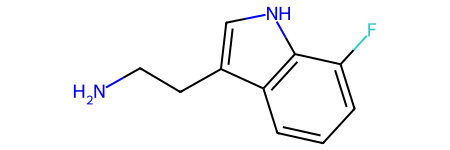

In [48]:
workpath=homepath+'/GPCR_agonist_GPRC5A'
os.chdir(workpath)

cpd_name='7-Fluorotryptamine'
smiles='C1=CC2=C(C(=C1)F)NC=C2CCN'
molecular=Chem.MolFromSmiles(smiles) 
activity=GPCR_prediction(workpath,cpd_name,smiles)
EC50_pred=np.power(10,activity)
print (cpd_name)
print('Predicted LogEC50: ',f'{activity:.2f}') 
print('Predicted EC50: ',f'{EC50_pred/1000:.1f}', 'uM')

print('')

EC50=7.2  # uM '7-Fluorotryptamine'
EC50_nM=EC50*1000
print('Experimental EC50 ',(EC50),'uM')
print('Experimental LogEC50 ',f'{math.log(EC50_nM,10):.2f}')

molecular

Tryptamine
Predicted LogEC50:  3.31
Predicted EC50:  2.0 uM


Experimental EC50:  88.9 uM
Experimental LogEC50:  4.95


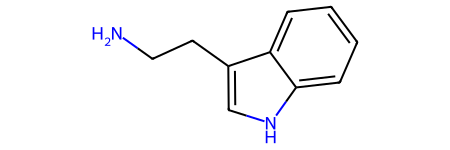

In [65]:
workpath=homepath+'/GPCR_agonist_GPRC5A'
os.chdir(workpath)

cpd_name='Tryptamine'
smiles='NCCC1=CNC2=CC=CC=C21'
molecular=Chem.MolFromSmiles(smiles) 
activity=GPCR_prediction(workpath,cpd_name,smiles)
EC50_pred=np.power(10,activity)
print (cpd_name)
print('Predicted LogEC50: ',f'{activity:.2f}') 
print('Predicted EC50: ',f'{EC50_pred/1000:.1f}', 'uM')

print('')

EC50=88.9  # uM 'Tryptamine'
EC50_nM=EC50*1000
print('\nExperimental EC50: ',(EC50),'uM')
print('Experimental LogEC50: ',f'{math.log(EC50_nM,10):.2f}')

molecular